In [93]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib
import glob
%pylab inline
import seaborn as sns
sns.set()

Populating the interactive namespace from numpy and matplotlib


/home/cusp/ir729/.conda/envs/JupyterVE/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
#import matplotlib.pyplot as plt
home = os.getenv('HOME') #Ilan's home directory
plumes = os.getenv('PLUMES') #plumes data

# Load the images

In [83]:
imgpath1 =  os.path.join(plumes,'outputs/tmp_*_median.npy')
#imgpath2 =  os.path.join(plumes,'outputs/tmp_01[345][0-9]_mindif.npy')

#print imgpath
imglist1 = sorted(glob.glob(imgpath1))
#imglist2 = sorted(glob.glob(imgpath2))
        

#print imglist
nimgs = len(imglist1)

#empty array to catch read images
imgs = np.zeros((nimgs, 1300, 4096))
    
#imgs_min = np.zeros((nimgs, 1300, 4096))


for i,f in enumerate(imglist1):
    #print(f)
    imgs[i] = np.load(f)[200:1500,:,:].mean(-1)

#for i,f in enumerate(imglist2):
    #print(f)
    #imgs_min[i] = np.load(f)[200:1500,:,:].mean(-1)

In [84]:
## Make copies of original list for better manipulation
img_tmp = imgs.copy()
#img_tmin = imgs_min.copy()
#img_filt = imgs.copy()
imgbw = np.empty_like(img_tmp)

In [205]:
# filter the images based on log-histogram. 

from skimage import color

#th = 10  #7, 10
for i in range(nimgs):
    #img_filt[i][img_filt[i] < th] = 0.0
    imgbw[i] = color.rgb2gray(img_tmp[i]) #set images to grayscale

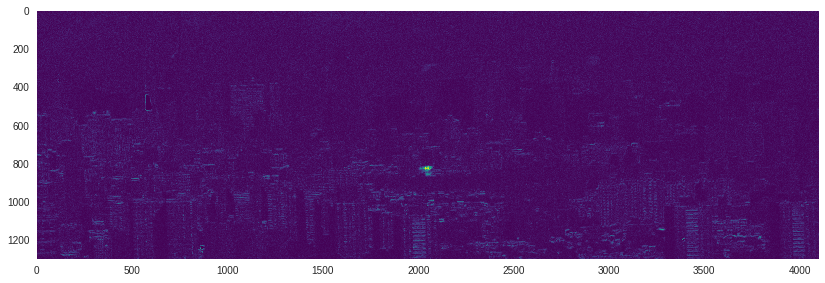

In [211]:
#First plot of image with plume as example
fig = figure(figsize = (14,10))
imshow(imgbw[137], cmap = 'viridis')

grid(False)

## Zoom into the different plumes and create histograms to see the behaviour

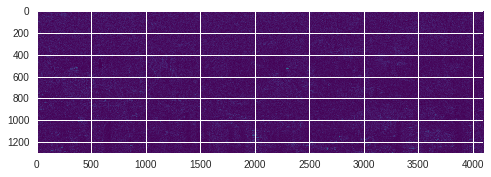

In [138]:
#Zoom into the plume to see how well defined it is after filtering
#imshow(imgbw[1], cmap = 'viridis')

In [11]:
#Histogram of the zoomed area
#hist(imgbw[12,800:900, 2000:2200].flatten(), log = True)
#hist(imgbw[12,810:865, 2000:2075].flatten(), alpha = 0.6)

In [12]:
#imshow(imgbw[16,590:750, 1950:2050], cmap = 'viridis')

In [13]:
#hist(imgbw[16,590:750, 1950:2050].flatten(), log = True)

In [14]:
#imshow(img_filt[17,400:800, 1700:2200], cmap = 'viridis')

In [15]:
#hist(img_filt[17,400:800, 1700:2200].flatten(), log = True)

In [16]:
#imshow(img_filt[18,400:650, 2000:2300], cmap = 'viridis')

In [17]:
#hist(img_filt[18,400:650, 2000:2300].flatten())

In [18]:
#imshow(img_filt[19,200:600, 2000:2500], cmap = 'viridis')

In [19]:
#hist(img_filt[19,200:600, 2000:2500].flatten(), log = True)

In [20]:
#imshow(img_filt[20,200:500, 2300:2700], cmap = 'viridis')

In [21]:
#hist(img_filt[20,200:500, 2300:2700].flatten(), log = True)

In [22]:
#BINS = 50#int(round(2*len(img_med[0].flatten())**(1./3.)))
#y_md = np.zeros((nimgs, BINS))
#y_mn = np.zeros((nimgs, BINS))
#x = np.zeros(BINS)
#patches = np.zeros(BINS) #third element of histogram tuple NOT USED


#for i in range(nimgs):    
    #y_md[i], x, patches = plt.hist(img_tmp[i].flatten(), bins = BINS, log = True)
    #y_mn[i] = plt.hist(imgs_min[i].flatten(), bins = BINS, log = True)[0]

In [23]:
#ymd_log = np.log10(y_md)

In [24]:
#ymd_log[np.isinf(ymd_log)] = 0.0

In [25]:
#bins_cen = x[:-1] + 0.5*(x[1]-x[0])

In [26]:
#cols = ['img%d'%(i) for i in range(nimgs)]

#median_data = pd.DataFrame(ymd_log.T, columns = cols)
#median_data.insert(0, 'X', bins_cen)

## Histogram of oriented gradients

Documentation: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html


In [27]:

#from skimage.feature import hog

#test, hogimg = hog(imgbw[15], orientations = 10, pixels_per_cell=(16, 16), 
 #                  cells_per_block=(4,4), visualise=True, block_norm='L1')

In [28]:
#figure(figsize = (12, 10))
#imshow(hogimg, cmap = 'viridis')
#grid(False)

In [29]:
#imshow(hogimg[580:780, 1800:2200], cmap = 'viridis')
#grid(False)

## Sobel filtering to detect edges of plumes

In [30]:
#from skimage import filters
#edg1 = filters.sobel(imgbw[15])

In [31]:
#figure(figsize = (12, 10))
#imshow(edg1, cmap = 'viridis')
#grid(False)

In [32]:
#imshow(edg1[580:780, 1800:2200], cmap = 'viridis')

In [33]:
#hist(edg1.flatten(), log = True)

In [34]:
#edges = np.empty_like(imgbw)
#for i in range(nimgs):
#    edges[i] = filters.sobel(imgbw[i])


Making binary images based on filtering the brightness differences.

In [213]:
label = np.zeros(nimgs)
imbin = np.empty_like(imgbw)
imvar = np.zeros(nimgs)
for i in range(nimgs):
    imbin[i] = np.where(imgbw[i] > 10, 1.0, 0.0)
    imvar[i] = imbin[i].sum()
    if imvar[i] > 1877 and imvar[i] < 40000:
        label[i] = 1.
    #print i, imvar[i]

0 1914.0
1 1456.0
2 28827.0
3 966.0
4 3095.0
5 18799.0
6 42836.0
7 20404.0
8 2392.0
9 8722.0
10 3529.0
11 988.0
12 654.0
13 2119.0
14 1348.0
15 750.0
16 990.0
17 701.0
18 1688.0
19 1545.0
20 505.0
21 474.0
22 672.0
23 1212.0
24 2465.0
25 824.0
26 1067.0
27 2006.0
28 811.0
29 734.0
30 868.0
31 627255.0
32 1186.0
33 20869.0
34 815.0
35 3197.0
36 3101.0
37 13492.0
38 766.0
39 71854.0
40 1478.0
41 944.0
42 2850.0
43 864.0
44 721.0
45 2928.0
46 493.0
47 1014.0
48 1089.0
49 873.0
50 830.0
51 1054.0
52 998.0
53 1503.0
54 1552.0
55 25289.0
56 1764.0
57 1566.0
58 974.0
59 1276.0
60 855.0
61 621.0
62 1177.0
63 10090.0
64 543.0
65 939.0
66 3212.0
67 1137.0
68 780.0
69 1868.0
70 2940.0
71 5881.0
72 799.0
73 899.0
74 1544.0
75 72816.0
76 5265.0
77 92622.0
78 18322.0
79 871.0
80 3920.0
81 900.0
82 1619.0
83 669.0
84 831.0
85 591.0
86 13863.0
87 850.0
88 1249.0
89 98707.0
90 543162.0
91 1173.0
92 15915.0
93 1992.0
94 1421.0
95 987.0
96 798.0
97 1740.0
98 3387.0
99 1375.0
100 3892.0
101 1700.0
102 207

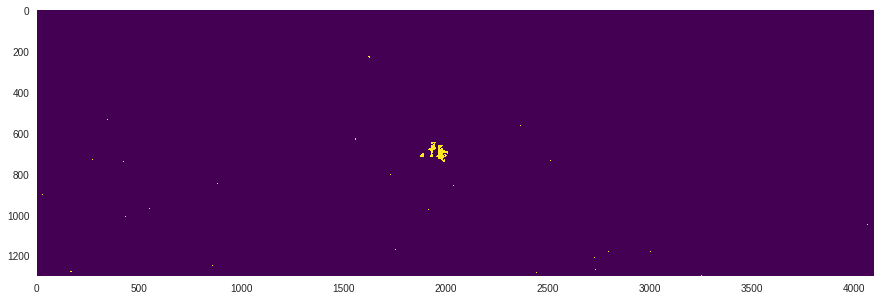

In [219]:
figure(figsize = (15, 15))
imshow(imbin[140], cmap = 'viridis')
grid(False)

In [220]:
label

array([ 1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
        1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,
        0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,
        0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,
        1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  0

In [221]:
blk = np.zeros((nimgs, 50, 128))
lbl = np.zeros(nimgs)
for k in range(nimgs):
    for i, x in enumerate(xrange(0,imbin[k].shape[0],26)):
        for j, y in enumerate(xrange(0,imbin[k].shape[1],32)):
            view = imbin[k,x:x+26, y:y+32]
            blk[k,i,j] = np.where(view.sum() > 130, 1., 0.)
            if blk[k].sum() >= 2. and blk[k].sum() < 30:
                lbl[k] = 1.

In [133]:
t = np.zeros(nimgs/10)
v = np.empty_like(t)
for i, j in enumerate(xrange(0, nimgs, 10)):
    v[i] = imvar[j:j+10].var()
    t[i] = i

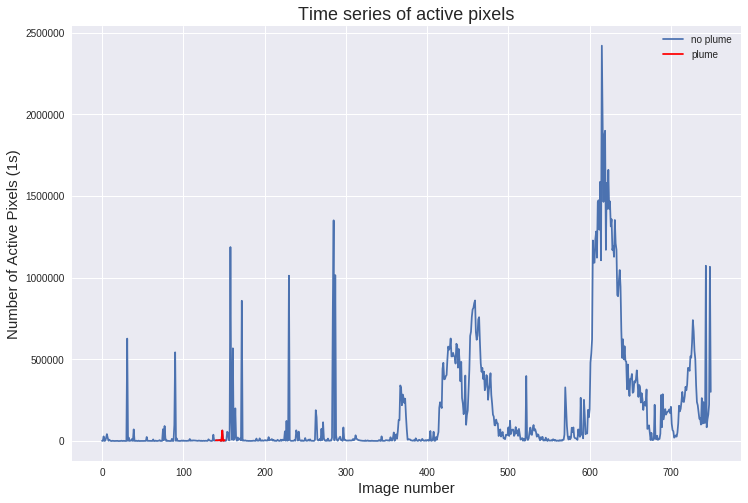

In [190]:
t2 = np.arange(750)
figure(figsize = (12, 8))
plot(t2,imvar)
plot(t2[137:149],imvar[137:149], color = 'r')
xlabel('Image number', size = 15)
ylabel('Number of Active Pixels (1s)', size = 15)
title('Time series of active pixels', size = 18)
legend(['no plume', 'plume'])

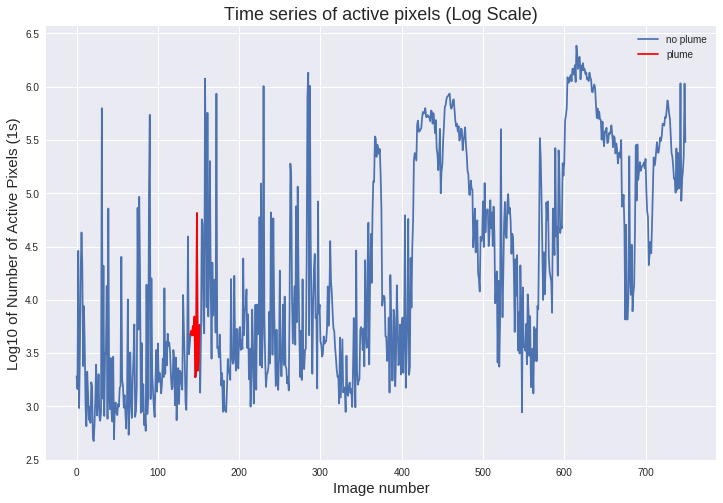

In [191]:

figure(figsize = (12, 8))
plot(t2,np.log10(imvar))
plot(t2[137:148],np.log10(imvar[137:148]), color = 'r')
xlabel('Image number', size = 15)
ylabel('Log10 of Number of Active Pixels (1s)', size = 15)
title('Time series of active pixels (Log Scale)', size = 18)
legend(['no plume', 'plume'])

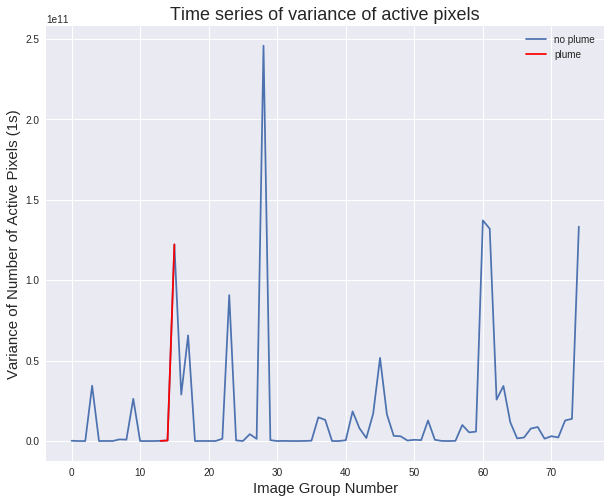

In [223]:
figure(figsize = (10,8))
plot(t,v)
plot(t[13:16],v[13:16], color = 'r')
xlabel('Image Group Number', size = 15)
ylabel('Variance of Number of Active Pixels (1s)', size = 15)
title('Time series of variance of active pixels', size = 18)
legend(['no plume', 'plume'])

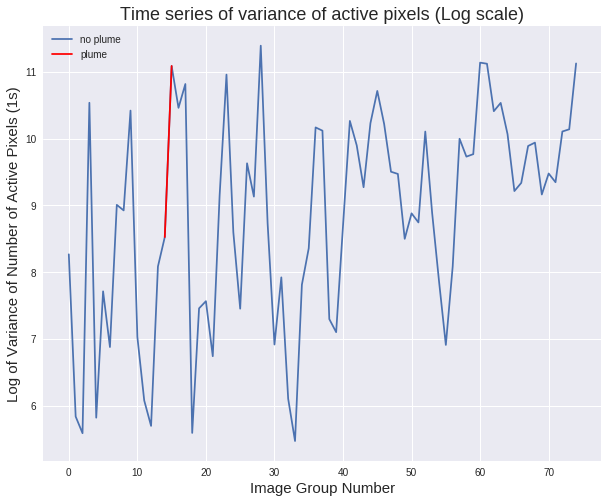

In [175]:
figure(figsize = (10,8))
plot(t,np.log10(v))
plot(t[14:16],np.log10(v[14:16]), color = 'r')
xlabel('Image Group Number', size = 15)
ylabel('Log of Variance of Number of Active Pixels (1s)', size = 15)
title('Time series of variance of active pixels (Log scale)', size = 18)
legend(['no plume', 'plume'])

In [248]:
X = imbin[137:149]
Xt = np.empty((12, 5324800))
for i in range(12):
    Xt[i] = X[i].flatten()

In [252]:
Xt.T

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])